code to predict pv generation

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# Third party packages.
import os                       # Execute tasks related to your operating system.

import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [18]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{CSV_DOWNLOAD_DIR}power-gen-consolidated-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:    
    df_pd_orig = pd.read_csv(csv_file)

# Sum of all columns starting with 'production'
# df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
df_pd_orig["Total_Production"] = df_pd_orig["production_all"]
df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,validto,Load,Price,Flow_BE_to_NL,Flow_NL_to_BE,Flow_DE_to_NL,Flow_NL_to_DE,Flow_GB_to_NL,Flow_NL_to_GB,Flow_DK_to_NL,...,production_otherpower,capacity_27,production_electricitymix,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
0,2022-01-01 00:00:00+00:00,10249.75,124.7,0.0,728.0,1314.0,425.50,0.0,591.0,582.0,...,241000,10246506,10246506,1127491,1127491,482,482,1865500,1865500,8098513
1,2022-01-01 01:00:00+00:00,9907.00,134.0,0.0,1070.0,1092.0,281.75,0.0,456.0,552.0,...,241000,10083044,10083044,1184195,1184195,391,391,1839500,1839500,7914843
2,2022-01-01 02:00:00+00:00,9782.50,58.8,0.0,344.0,1372.5,849.25,412.0,0.0,237.0,...,241000,9595627,9595627,1181864,1181864,444,444,1429250,1429250,7442013


Descriptive Statistics

In [19]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 74 numerical variables:
Index(['Load', 'Price', 'Flow_BE_to_NL', 'Flow_NL_to_BE', 'Flow_DE_to_NL',
       'Flow_NL_to_DE', 'Flow_GB_to_NL', 'Flow_NL_to_GB', 'Flow_DK_to_NL',
       'Flow_NL_to_DK', 'Flow_NO_to_NL', 'Flow_NL_to_NO', 'Flow_BE', 'Flow_DE',
       'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow', 'index',
       'temperature_2m', 'apparent_temperature', 'cloud_cover',
       'wind_speed_10m', 'diffuse_radiation', 'direct_normal_irradiance',
       'shortwave_radiation', 'wind_speed_100m', 'capacity_0',
       'production_all', 'capacity_1', 'production_wind', 'capacity_2',
       'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8',
       'production_cofiring', 'capacity_9', 'production_geothermal',
       'capacity_10', 'production_other', 'capacity_11', 'production_waste',
       'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass',
       'capacity_14', 'production_wood', 'capacity_17',
       'production_windoffshore', 'capacit

To check if the output column has unique values

In [20]:
l_col = ['Total_Production']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Total_Production']:        Total_Production
0               8098513
1               7914843
2               7442013
3               7470598
4               7425668
...                 ...
26298          15694667
26299          15441356
26300          15390012
26301          15298923
26302          15150733

[26303 rows x 1 columns]
Total_Production: [ 8098513  7914843  7442013 ... 15390012 15298923 15150733]


Contruct a descriptive summary

In [21]:
df_pd_orig.describe()

,Load,Price,Flow_BE_to_NL,Flow_NL_to_BE,Flow_DE_to_NL,Flow_NL_to_DE,Flow_GB_to_NL,Flow_NL_to_GB,Flow_DK_to_NL,Flow_NL_to_DK,...,production_otherpower,capacity_27,production_electricitymix,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
count,26303.000000,26300.000000,26303.000000,26303.000000,26303.000000,26303.000000,26301.000000,26301.000000,26303.000000,26303.000000,...,26303.000000,2.630300e+04,2.630300e+04,2.630300e+04,2.630300e+04,26303.000000,26303.000000,2.630300e+04,2.630300e+04,2.630300e+04
mean,12349.026309,138.299306,247.454663,767.337642,809.419353,949.103030,201.165136,430.358833,293.654336,179.525567,...,227660.837167,1.352912e+07,1.352912e+07,1.663089e+06,1.663089e+06,42419.861917,42419.861917,1.308791e+06,1.308791e+06,1.002862e+07
std,2038.897514,113.143857,491.021658,817.858597,767.763152,1003.446814,344.765537,442.343338,308.965983,272.342184,...,9426.206535,4.009787e+06,4.009787e+06,6.544322e+05,6.544322e+05,65693.005587,65693.005587,1.068527e+06,1.068527e+06,4.730926e+06
min,5383.250000,-500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,221000.000000,3.476983e+06,3.476983e+06,4.414480e+05,4.414480e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,2.495282e+06
25%,10824.500000,75.900000,0.000000,0.000000,79.125000,8.000000,0.000000,0.000000,0.000000,0.000000,...,221000.000000,1.049227e+07,1.049227e+07,1.177196e+06,1.177196e+06,355.000000,355.000000,3.720005e+05,3.720005e+05,6.200884e+06
50%,12154.750000,106.195000,0.000000,532.000000,690.000000,662.250000,0.000000,287.750000,131.000000,0.000000,...,221000.000000,1.326906e+07,1.326906e+07,1.566629e+06,1.566629e+06,1934.000000,1934.000000,1.060500e+06,1.060500e+06,9.336498e+06
75%,13638.750000,174.712500,257.000000,1331.000000,1276.750000,1569.750000,305.500000,946.250000,683.000000,381.000000,...,241000.000000,1.640102e+07,1.640102e+07,2.025640e+06,2.025640e+06,63787.500000,63787.500000,2.090000e+06,2.090000e+06,1.302594e+07
max,19477.250000,872.960000,3709.000000,4181.000000,5146.500000,5949.000000,1060.250000,1090.250000,835.000000,701.000000,...,241000.000000,2.967770e+07,2.967770e+07,3.940000e+06,3.940000e+06,296529.000000,296529.000000,4.342999e+06,4.342999e+06,2.918097e+07


Prepare data for prediction

In [22]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

# Step 3: Split the data into train and test based on time (using a percentage split)
train_size = int(len(df) * 0.8)  # 80% for training
train = df[:train_size].copy()  # Using the first 80% for training
test = df[train_size:].copy()   # Using the last 20% for testing


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 4846610.721626726
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716746400]  ┆ 8652085  ┆ 10970458  ┆ -2318373 │
│ [1716750000]  ┆ 7607086  ┆ 10970557  ┆ -3363471 │
│ [1716753600]  ┆ 6375233  ┆ 10970655  ┆ -4595422 │
│ [1716757200]  ┆ 6175355  ┆ 10970753  ┆ -4795398 │
│ [1716760800]  ┆ 6343846  ┆ 10970852  ┆ -4627006 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735668000]  ┆ 15694667 ┆ 11487103  ┆ 4207564  │
│ [1735671600]  ┆ 15441356 ┆ 11487201  ┆ 3954155  │
│ [1735675200]  ┆ 15390012 ┆ 11487300  ┆ 3902712  │
│ [1735678800]  ┆ 15298923 ┆ 11487398  ┆ 3811525  │
│ [1735682400]  ┆ 15150733 ┆ 11487496  ┆ 3663237  │
└───────────────┴──────────┴───────────┴──────────┘


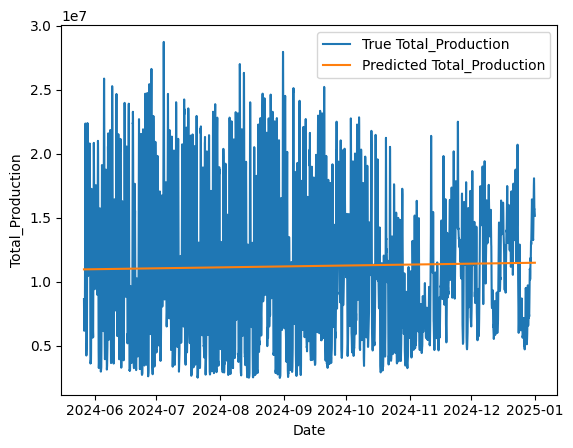

In [24]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Total_Production']  # 'Total_Production' as the target

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['Total_Production']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)



# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

Predict using LASSO model

In [25]:

# Train Lasso Regression Model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)


Mean Absolute Error: 4846610.721626724
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716746400]  ┆ 8652085  ┆ 10970458  ┆ -2318373 │
│ [1716750000]  ┆ 7607086  ┆ 10970557  ┆ -3363471 │
│ [1716753600]  ┆ 6375233  ┆ 10970655  ┆ -4595422 │
│ [1716757200]  ┆ 6175355  ┆ 10970753  ┆ -4795398 │
│ [1716760800]  ┆ 6343846  ┆ 10970852  ┆ -4627006 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735668000]  ┆ 15694667 ┆ 11487103  ┆ 4207564  │
│ [1735671600]  ┆ 15441356 ┆ 11487201  ┆ 3954155  │
│ [1735675200]  ┆ 15390012 ┆ 11487300  ┆ 3902712  │
│ [1735678800]  ┆ 15298923 ┆ 11487398  ┆ 3811525  │
│ [1735682400]  ┆ 15150733 ┆ 11487496  ┆ 3663237  │
└───────────────┴──────────┴───────────┴──────────┘


/opt/miniconda3/envs/enexis-data-visualization/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.970e+13, tolerance: 4.220e+13
  model = cd_fast.enet_coordinate_descent(


Predict using decision tree regression

In [26]:

# Train Decision Tree Regressor Model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)



Mean Absolute Error: 4683262.467912206
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716746400]  ┆ 8652085  ┆ 10066337  ┆ -1414252 │
│ [1716750000]  ┆ 7607086  ┆ 10066337  ┆ -2459251 │
│ [1716753600]  ┆ 6375233  ┆ 10066337  ┆ -3691104 │
│ [1716757200]  ┆ 6175355  ┆ 10066337  ┆ -3890982 │
│ [1716760800]  ┆ 6343846  ┆ 10066337  ┆ -3722491 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735668000]  ┆ 15694667 ┆ 10066337  ┆ 5628330  │
│ [1735671600]  ┆ 15441356 ┆ 10066337  ┆ 5375019  │
│ [1735675200]  ┆ 15390012 ┆ 10066337  ┆ 5323675  │
│ [1735678800]  ┆ 15298923 ┆ 10066337  ┆ 5232586  │
│ [1735682400]  ┆ 15150733 ┆ 10066337  ┆ 5084396  │
└───────────────┴──────────┴───────────┴──────────┘


Predit using Random Forest regressor

In [27]:

# Train Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = rf_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

Mean Absolute Error: 4849969.833408097
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716746400]  ┆ 8652085  ┆ 11225195  ┆ -2573110 │
│ [1716750000]  ┆ 7607086  ┆ 11225195  ┆ -3618109 │
│ [1716753600]  ┆ 6375233  ┆ 11225195  ┆ -4849962 │
│ [1716757200]  ┆ 6175355  ┆ 11225195  ┆ -5049840 │
│ [1716760800]  ┆ 6343846  ┆ 11225195  ┆ -4881349 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735668000]  ┆ 15694667 ┆ 11225195  ┆ 4469472  │
│ [1735671600]  ┆ 15441356 ┆ 11225195  ┆ 4216161  │
│ [1735675200]  ┆ 15390012 ┆ 11225195  ┆ 4164817  │
│ [1735678800]  ┆ 15298923 ┆ 11225195  ┆ 4073728  │
│ [1735682400]  ┆ 15150733 ┆ 11225195  ┆ 3925538  │
└───────────────┴──────────┴───────────┴──────────┘


'\nMODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]\nmodel_pkl_file_path = f\'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl\'\nprint("model_pkl_file_path :", model_pkl_file_path)\n\n# Save the trained model\njoblib.dump(rf_regressor, model_pkl_file_path, compress=3)\nprint("Model saved successfully!")\'\'\n'